# 分子动力学仿真与部分子散射

庞龙刚@华中师范大学

## 学习内容

1. 分子动力学仿真
2. 高能核物理中的分子动力学模拟
2. $e^+ + e^- \rightarrow \mu^+ + \mu^-$ 准弹性散射
3. 部分子弹性散射微分截面
4. Linear Boltzmann Transport (LBT) Model
5. Parton cascade (AMPT and BUMP)

In [1]:
# 使用的 python 库
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
from ipywidgets import interact
from tqdm import tqdm
import numpy as np
import vegas

plt.style.use(["science", "notebook", 'no-latex'])

## 分子动力学仿真

上一节介绍了哈密顿系统的辛几何算法，在分子动力学仿真中，经常使用 Stormer-Verlet 算法为保辛算法。

\begin{align}
x^{n+1} = 2 x^{n} - x^{n-1} + a^n \Delta t^2
\end{align}

Verlet 算法使用两个时间步的位置以及第 n 个时间步的加速度 $a$，来更新分子在 n+1 时间步的位置。
加速度 $a$ 来源于周围分子的弱吸引力，比如对于二维系统， 

\begin{align}
a_{i, x} = {1 \over m_i} \sum_j F_{ij} \cos \theta_{ij} \\
a_{i, y} = {1 \over m_i} \sum_j F_{ij} \sin \theta_{ij} \\
\end{align}

其中 $F_{ij}$ 是第 j 个原子对目标原子 i 的作用力。

力等于势能的负梯度， $ F = - \partial V(r) / \partial r$，分子动力学模拟需要知道分子间相互作用势能。

原子、分子本身不带电，但原子分子之间存在长程库伦相互作用，这种相互作用被称为 Van der Waals 力。Van der Waals 力主要来源于极性分子的永久电偶极矩，或非极性分子瞬时电偶极矩引起的库伦力，它提供了正比于 $r^{-6}$ 的相互作用势能。
当两个原子非常靠近时，又由于电子云重叠造成排斥，为分子间相互作用贡献了 $r^{-12}$ 项。

两项相加得到分子间相互作用势能的 Lennard-Jones 势，

\begin{align}
V(r) = 4 \epsilon \left[({\sigma \over r})^{12} - ({\sigma \over r})^6 \right]
\end{align}
其中 $\sigma$ 和 $\epsilon$ 为参数。

这里简单介绍一下传统的分子动力学模拟，比如大量 Ar 原子分子组成的系统。

Ar（Z=18, N=22）是单原子分子，Ar-Ar 相互作用可以用 Lennard-Jones 势很好的描述。

\begin{align}
V(r) = 4 \epsilon \left[({\sigma \over r})^{12} - ({\sigma \over r})^6 \right]
\end{align}

对于 Ar 原子气体，$\sigma=3.4 \overset{\circ}A$, 系数 $\epsilon = k_B \times 120 K$。

每个 Ar 原子受到了周围其他 Ar 原子的力为 $ F = - \partial V(r) / \partial r$，其中 r 是连接目标 Ar 原子与其他 Ar 原子的直线距离。

如果设 $\sigma = \epsilon = 1$, 则第 k 个 Ar 原子分子受到第 j 个 Ar 原子分子的作用力为，

\begin{align}
F_{kj} = - {\partial V \over \partial r_{kj}} = 24 \left[{2 \over r_{kj}^{13}} - {1 \over r_{kj}^7} \right]
\end{align}

此处 $r_{kj}$ 为 k 与 j 之间的距离。

(-1.5, 2.0)

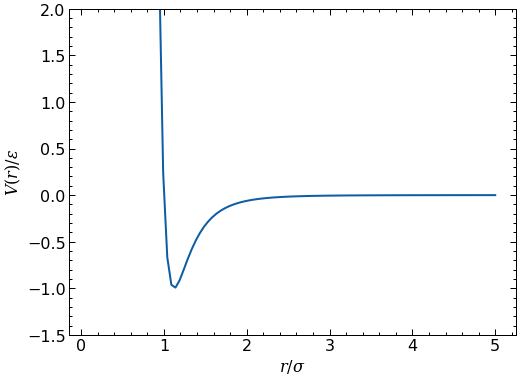

In [2]:
def V(r, sigma, eps):
    t = sigma / r
    return 4 * eps * (t**12 - t**6)

r = np.linspace(0.1, 5, 100)
plt.plot(r, V(r, 1, 1))
plt.xlabel(r'$r / \sigma$')
plt.ylabel(r'$V(r)/\epsilon$')
plt.ylim(-1.5, 2)

(-3.0, 2.0)

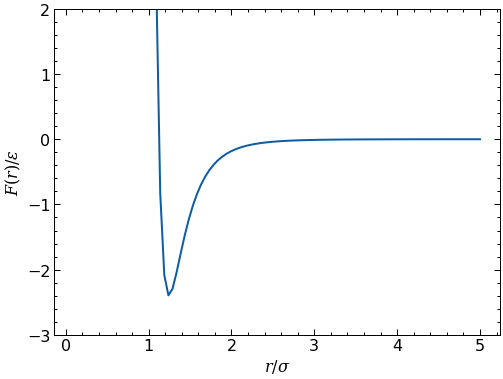

In [3]:
# Ar - Ar 分子之间的相互作用力作为距离的函数
def force(r, cutoff=1.0E-6):
    r = r + cutoff
    return 24 * (2 / r**13 - 1/r**7)

plt.plot(r, force(r))
plt.xlabel(r'$r / \sigma$')
plt.ylabel(r'$F(r)/\epsilon$')
plt.ylim(-3, 2)

**Ar 原子分子仿真的步骤 I -- 初始化**：

1. 选择粒子个数 N, 系统大小 L
2. 选择计算时间步长 $\Delta t$, 根据 $\sigma$ 和 $\epsilon$ 可以估计 $\tau=10^{-12}s$
3. 设置所有 N 个 Ar 原子的初始位置与速度
   - 对于初始位置，可将粒子等间距放置在格点上 $(x_i = x_0+i\ dx, y_i=y_0+j\ dy)$，然后提供微小扰动，防止初始时刻两原子重叠
   - 扰动方案：$x_i = x_i + dx$, $y_i = y_i + dy$, 其中 $dx, dy \sim U[-\delta r, \delta r]$
   - 初始速度：可以随机的设 $v_x, v_y \sim U[-v_{max}, v_{max}]$
   - 为了启动 Verlet 算法，还需要根据当前位置和速度，计算前一时刻的位置 ($x_{prev} = x_0 - v_x \Delta t$, ...)

**Ar 原子分子仿真的步骤 II -- 迭代更新**：

1. 对所有 N 个粒子，迭代更新它们的坐标与位置
   - 对第 i 个粒子，计算它与所有其他粒子 j 的距离 $r_{ij}$, 如果 $r_{ij} < r_{cut}$, 则将它受到的力累加。
   - 使用 Verlet 算法 $x^{n+1} = 2x^{n} - x^{n-1} + F_i/m (\Delta t)^2$ 更新第 i 个粒子的坐标 （如果超出计算区域，使用周期性边界条件）
   - 如果需要统计速度分布，计算第 i 个粒子的速度 $v_x = (x^{n+1} - x^{n-1})/(2 \Delta t)$
   

2. 接下来，对所有 N 个粒子，更新它们的标签
   - 将当前位置标记为前一个位置
   - 将新计算的位置标记为当前位置
   - 将希望保存的量，比如速度分布，总的动能，势能，系统的熵

虽然初始速度分布随机，但经过一段时间的演化，达到平衡时经典气体分子的速度满足 Maxwell 分布。
对于 2 维气体，有速度分布公式，

\begin{align}
P(v) = C {v^2 \over k_B T} \exp \left( - {m v^2 \over 2 k_B T} \right)
\end{align}

沿 x 方向的速度分布满足，

\begin{align}
P(v_x) =  {C_x \over \sqrt{k_B T}} \exp \left( - {m v_x^2 \over 2 k_B T} \right)
\end{align}

同理得到沿 y 方向的速度分布 $P(v_y)$。

练习：使用 Verlet 算法模拟 Ar 原子气体系统达到平衡时的速度分布，并提取其温度，并与 $k_B T = \langle {m \over 2}(v_x^2 +v_y^2) \rangle $对比。

### 编程实现分子动力学仿真 Molecular Dynamical Simulation

1. 计算大量分子两两之间的距离、以及相互作用势能

使用 scipy.spatial.distance 中的 pdist 函数，计算每对粒子之间的距离 $r_{ij}$,

输入为一个 m*n 维数组 x。数组每一行存储一个粒子的 n 个空间坐标。

- m 表示粒子个数
- n 表示空间维数

pdist 返回 $r_{ij}$ 压缩过的格式，即只保留 i < j < k .... 的对。

粒子与它自己的距离为0，即 $i == j$ 时，$r_{ii}=0$。
对于 j>i, $r_{ji} = r_{ij}$, 属于重复信息。

使用 scipy.spatial.distance 中的 squareform 可以将 pdist 的输出转化为方阵格式。

In [4]:
from scipy.spatial.distance import pdist as pair_distance
from scipy.spatial.distance import squareform

x = np.array([[1, 1],      # 1st point in 2d space
              [1, 2],      # 2nd point in 2d space
              [2, 1]])     # 3rd point in 2d space

# 返回 12, 13, 23 两两之间的欧几里得距离
pair_distance(x)

array([1.        , 1.        , 1.41421356])

In [5]:
# 使用自定义函数，计算两两之间的 dx， dy
def pair_dxdy(coords):
    x, y = coords[:, 0], coords[:, 1]
    # 使用 np.newaxis 将 x 变为 1 行 n 列 与 n 行 1 列的数组
    dx = x[:, np.newaxis] - x[np.newaxis, :]
    dy = y[:, np.newaxis] - y[np.newaxis, :]
    return dx, dy

pair_dxdy(x)

(array([[ 0,  0, -1],
        [ 0,  0, -1],
        [ 1,  1,  0]]),
 array([[ 0, -1,  0],
        [ 1,  0,  1],
        [ 0, -1,  0]]))

In [6]:
def force_ArAr(coords, cutoff=1.0E-6, mass=1):
    '''Assume force=0 if rij > rmax'''
    rij = pair_distance(coords)
    # Ar - Ar 分子之间的相互作用力作为距离的函数
    r = rij + cutoff
    fij = 24 * (2 / r**13 - 1/r**7)
    dx, dy = pair_dxdy(coords)
    fij = squareform(fij)
    r = squareform(r) + np.identity(len(coords))
    fx = fij * dx / r      # fij * cos theta
    fy = fij * dy / r      # fij * sin theta
    fx = np.sum(fx, axis=1)
    fy = np.sum(fy, axis=1) 
    return np.array([fx, fy]).T / mass

force_ArAr(x)

array([[-23.99952   , -23.99952   ],
       [  1.12499523,  22.87452478],
       [ 22.87452478,   1.12499523]])

2. 构造粒子所在的几何区域

分子动力学仿真一般从最简单的 box 模型开始，假设所有粒子的运动局限于一个长宽高都为 L 的盒子中。

这里我们做一个 2 维仿真，盒子只有长、宽。

定义一些辅助变量，比如盒子的最左边 xmin, 最右边 xmax, 最上边 ymax 与最下边 ymin。

这些辅助变量对于分子动力学仿真很有用。

In [7]:
# 构造 box 的几何参数
from matplotlib.patches import Rectangle

class Box2D:
    def __init__(self, L=10):
        self.L = L
        self.width = L
        self.height = L
        self.xmin = - 0.5 * L
        self.xmax = 0.5 * L
        self.ymin = - 0.5 * L
        self.ymax = 0.5 * L
    
    def plot(self):
        xy = (self.xmin, self.ymin)
        box_ = Rectangle(xy, self.width, self.height, fill=False)
        plt.gca().add_patch(box_)
        plt.xlim(self.xmin-1, self.xmax+1)
        plt.ylim(self.ymin-1, self.ymax+1)
        plt.axis('off')
        plt.gca().set_aspect('equal')

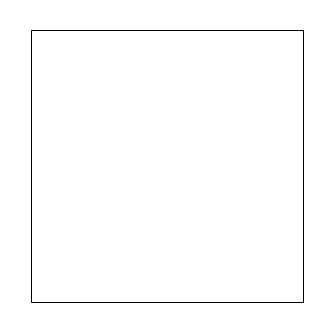

In [8]:
box = Box2D()
box.plot()

开始构造一个分子动力学模拟系统


- 初始化：$x_{\rm prev}$, $x_{\rm curr}$, $x_{\rm new}$, $v$
- 时间迭代：按 $\Delta t$ 步长逐步更新粒子的空间坐标
    1. 计算每个粒子受力、加速度
    2. 使用 Verlet 公式更新粒子坐标
    3. 对 $x_{\rm prev}$, $x_{\rm curr}$ 更新标签 

In [9]:
class MolecularDynamics:
    def __init__(self, dims=2, N=10, L=10, dt=0.01, rmax=4, vmax=1):
        self.dt = dt
        self.n = N
        self.xprev = np.zeros(shape=(N, dims))
        self.xcurr = np.zeros(shape=(N, dims))
        self.xnew = np.zeros(shape=(N, dims))
        self.v = np.random.uniform(-vmax, vmax, size=(N, dims))

        self.box = Box2D(L)
        self.r_cutoff = rmax
        self.initialization()
        
    def initialization(self, dr=0.2):
        xmin = self.box.xmin + 0.1 * self.box.width
        xmax = self.box.xmax - 0.1 * self.box.width
        # 构造方形的规则的格点，初始化分子位置
        sqrtn = int(np.sqrt(self.n)) + 1
        x = np.linspace(xmin, xmax, sqrtn)
        xx, yy = np.meshgrid(x, x)
        self.xcurr[:, 0] = xx.flatten()[:self.n]
        self.xcurr[:, 1] = yy.flatten()[:self.n]
        self.xcurr += np.random.uniform(-dr, dr,
                                size=(self.n, 2))
        self.xprev = self.xcurr - self.v * self.dt
         
    def update(self, force_func):
        a = force_func(self.xcurr)
        self.xnew = 2 * self.xcurr - self.xprev + a * self.dt**2
        self.xprev = self.xcurr
        self.xcurr = self.xnew
        self.xprev = self.periodic_boundary(self.xprev)
        self.xcurr = self.periodic_boundary(self.xcurr)
        
     
    def periodic_boundary(self, coords):
        # 周期性边界条件条件
        b = self.box
        # 这个简单实现中，如果两个分子放置的距离足够近，会引起系统势能瞬间增大
        coords = np.where(self.xnew > b.xmax, coords - b.L, coords)
        coords = np.where(self.xnew < b.xmin, coords + b.L, coords)
        return coords
        
    def plot(self):
        self.box.plot()
        plt.scatter(self.xcurr[:, 0], self.xcurr[:, 1])
        

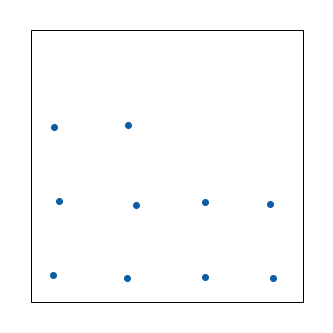

In [10]:
M = MolecularDynamics()
M.plot()

In [11]:
from ipywidgets import widgets

step = widgets.Play(
    value=50,
    min=0,
    max=10000,
    step=1,
    interval=1,
    description="Press play",
    disabled=False
)
M = MolecularDynamics()
def plot_update(n=0):
    M.update(force_ArAr)
    M.plot()
    
box_anim = interact(plot_update, n=step)

interactive(children=(Play(value=50, description='Press play', interval=1, max=10000), Output()), _dom_classes…

## 高能核物理中的分子动力学模拟

主要应用包括，

1. Parton cascade，描述大量夸克、胶子的散射
   - ZPC, BAMPS
2. Hadronic cascade, 描述大量强子（重子与介子）的散射
   - UrQMD，SMASH
3. 部分子与强子散射混合仿真
   - AMPT, PACIA

高能核物理中的分子动力学仿真与计算化学中的分子动力学仿真有所不同。

1. Lennard-Jones 势能为长程势，每个分子同时受到多个分子的吸引力
2. 在低能核物理中，考虑核子在多个核子的平均场中的运动，与计算化学中的分子动力学仿真相似
3. 在高能核物理中，一般只考虑稀薄系统，不考虑长程多体相互作用
4. 高能核物理一般使用无碰撞时粒子的 free streaming 和参加碰撞时动量方向、大小的改变来进行分子动力学仿真

free streaming 的定义：

有大量粒子，但是粒子与粒子之间无散射，每个粒子按照各自的动量做匀速直线运动。

粒子碰撞的定义：

在传统分子动力学仿真中，碰撞通过相互作用势能连续的更新粒子的坐标与动量来实现；

在高能粒子物理中，碰撞是更基本的过程，相互作用通过传播子传递。

相互作用势能可以使用场论中的费曼图计算得到。

## $e^+ + e^- \rightarrow \mu^+ + \mu^-$ 准弹性散射

为了理解高能物理中分子动力学仿真，先观察一个基本的物理过程 -- $e^+ + e^- \rightarrow \mu^+ + \mu^-$ 准弹性散射。

$e^+ + e^- \rightarrow \mu^+ + \mu^-$ 准弹性散射的微分散射截面 （differential cross section） 为，

\begin{align}
{d \sigma \over d\cos \theta d \phi} = {\alpha^2 \over 4 s} (1 + \cos^2\theta)
\end{align}

质心系中，产生的 $\mu^+$ 和 $\mu^-$ 在动量空间中背对背, 需要知道质心系能量平方 $s$, 并抽样 $\theta$ 和 $\phi$ 得到末态粒子的四动量。无外磁场时，根据轴对称，散射方位角 $\phi$ 服从 $2\pi$ 内的均匀分布，

\begin{align}
\phi &= 2\pi r_1 
\end{align}

其中 $r_1 \sim U[0, 1]$。

### “加分布”抽样

如何对极角（或称散射角）满足的分布函数 $1 + \cos^2 \theta$ 抽样？

可以定义一个新的随机变量 $x = \cos\theta$, 且  $-1 \le x \le 1$ ，则极角的概率

\begin{align}
{d \sigma \over d\cos \theta } = 1 + \cos^2\theta
\end{align}

可以写为，

\begin{align}
{d \sigma \over d x } = 1 + x^2
\end{align}

对于 $1 + x^2$, 我们使用“加分布”抽样。即如果分布密度函数由两部分组成，

\begin{align}
f(x) = f_1(x) + f_2(x)
\end{align}
可以先计算两者的概率比,

\begin{align}
p_1 : p_2 = \int_{-\infty}^{\infty} f_1 dx : \int_{-\infty}^{\infty} f_2 dx
\end{align}


使用离散型随机变量, 按概率决定究竟使用 $f_1$ 还是 $f_2$ 抽样。

此处， $f(x) = f_1(x) + f_2(x) = 1 + x^2$, 两部分的概率比为，

\begin{align}
p_1 : p_2 = \int_{-1}^{1} 1 dx : \int_{-1}^{1} x^2 dx = 1 : {1 \over 3}
\end{align}

所以，有 $ {1 \over 1 + 1/3} = {3 \over 4}$ 的概率按均匀分布 $x  \sim U(-1, 1)$抽样，

另有 ${1/3 \over 1 + 1/3} = {1 \over 4}$ 的概率按 $f_2(x) = x^2$ 抽样，使用直接法，能计算出 $x = r^{1/3}$, 即

\begin{align}
\cos\theta &= {3 \over 4} r : {1 \over 4} r^{1/3}
\end{align}

其中 $r \sim U(-1, 1)$,。

In [12]:
def ee2mumu(n = int(1.0E6), s = 200):
    ''' 
    :n: num of events
    :s: The center of mass energy, s = (p1 + p2)**2, in unit [GeV^2]'''
    alpha = 1 / 137.
    coef = alpha**2 / (4. * s)
    r1 = np.random.rand(n)
    r2 = 2 * np.random.rand(n) - 1
    # r1: 决定使用 f1 还是 f2 抽样
    cos_theta = np.where(r1 < 0.75, r2, np.cbrt(r2))
    plt.hist(cos_theta, bins=100, color='grey', density=True, label="monte carlo")
    x = np.linspace(-1, 1, 100)
    plt.plot(x, (1 + x**2)*3/8, 'r-', label="ground truth")
    plt.title(r"$e^+ + e^- \rightarrow \mu^+ + \mu^-$")
    plt.xlabel(r"$\cos\theta$")
    plt.ylabel("probability")
    plt.legend(loc='best')
    return cos_theta

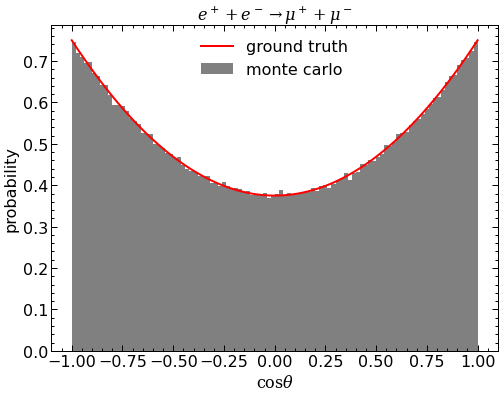

In [13]:
# mu^+, mu^- 散射的极角分布
mu_cos_theta = ee2mumu()

In [14]:
def ee_collision_demo(eid=0):
    cos_theta = mu_cos_theta[eid]
    sin_theta = np.sqrt(1 - cos_theta**2)
    p=5
    pz = p * cos_theta
    pt = p * sin_theta
    mu1 = (pz, pt)
    mu2 = (-pz, -pt)
    
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    lw = 0.5
    e1 = plt.Arrow(-5, 0, 4.8, 0, color='k', width=lw)
    e2 = plt.Arrow(5, 0, -4.8, 0, color='k', width=lw)
    plt.text(-4, 1, r'$e^+\ (p_1)$', size=20)
    plt.text(4, 1, r'$e^-\ (p_2)$', size=20)
    plt.gca().add_patch(e1)
    plt.gca().add_patch(e2)
    dz, dy = 0.02 * pz, 0.02 * pt
    m1 = plt.Arrow(dz, dy, pz, pt, color='r', width=lw, alpha=0.4)
    m2 = plt.Arrow(-dz, -dy, -pz, -pt, color='r', width=lw, alpha=0.4)
    plt.gca().add_patch(m1)
    plt.gca().add_patch(m2)
    
    plt.text(pz + 0.5, pt + 0.5, r'$\mu^+\ (p_3)$', size=20)
    plt.text(-pz + 0.5, -pt + 0.5, r'$\mu^-\ (p_4)$', size=20)
    plt.gca().axis('off')

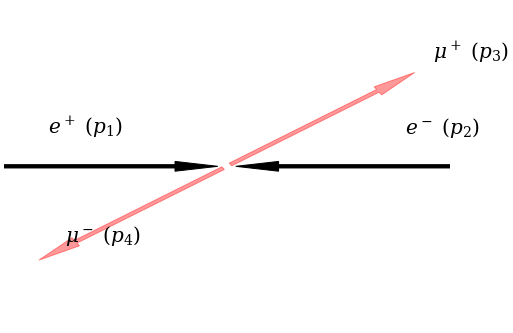

In [15]:
ee_collision_demo(eid=0)

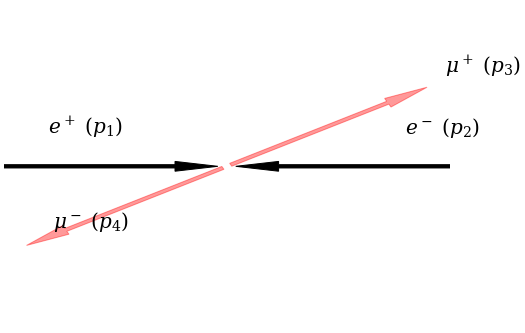

In [16]:
ee_collision_demo(eid=4)

In [17]:
interact(ee_collision_demo, eid=(0, 10000))

interactive(children=(IntSlider(value=0, description='eid', max=10000), Output()), _dom_classes=('widget-inter…

<function __main__.ee_collision_demo(eid=0)>

### 部分子弹性散射截面

部分子是夸克（quark）和胶子（gluon）的统称。

\begin{align}
\sigma_{ij\rightarrow kl}(s) \propto \int_{-s+m^2}^{-m^2} dt |M|^2_{ij\rightarrow kl}
\end{align}

其中 Mandelstam 变量 (s, t, u) 为，

\begin{align}
s = (p_1 + p_2)^2 \\
t = (p_1 - p_3)^2 \\
u = (p_1 - p_4)^2
\end{align}

这几个变量都是 Lorentz 不变量，

且容易验证 $s + t + u = m_1^2 + m_2^2 + m_3^2 + m_4^2$，即三者不独立，第3个可以用其它两个表示。

计算 Feymann 图中的树图，得到不同通道的散射振幅的平方，
<img src="images/parton_scattering_MijSquare.png" style="height:550px"></img>
其中 $g_s^2 = 4\pi \alpha_s$, 在不考虑 running coupling 的情况下，代码中一般取 $\alpha_s=0.3$。

## Linear Boltzmann Transport Model 中高能部分子与QGP中 thermal parton 的弹性散射

根据参考文献【1，2】，高能部分子 i 与热密 QGP 中的部分子 j 散射，末态为 k 和 l 的散射率为，

\begin{align}
\Gamma_{ij\rightarrow kl} = {1 \over 16 \pi^2 E_1^2}\int_{m^2 \over 2E_1}^{\infty} dE_2 f_j(E_2) \Omega_{ij \rightarrow kl}(E_1, E_2, m^2)
\end{align}

（回忆卢瑟福散章节 $dP = n\sigma dz$）其中，

\begin{align}
\Omega_{ij\rightarrow kl}(E_1, E_2, m^2) = {1 \over 1 + \delta_{kl}}{1 \over 16 \pi}\int_{2 m^2}^{4 E_1 E_2} ds \left[ {1 \over s} \int_{-s +m^2}^{-m^2} dt |M|^2_{ij \rightarrow kl} \right]
\end{align}

这是一个数值三重积分问题，可以用 Vegas 积分计算各种通道的 $\Gamma_{ij\rightarrow kl}$。

**数值仿真步骤**：

1. 构造散射通道的插值表：对不同的入射部分子能量 $E_1$, 不同的 QGP 局域温度 $T$, 计算各散射通道的相对比例 $\Gamma_{ij\rightarrow kl}$, 生成插值表 GammaIJ2KL[num_channels][num_jetE1][num_T]


2. 对于 QGP 中某给定时空位置的高能部分子 (quark or gluon），已知部分子能量 $E_1$, QGP 局域温度 $T$, 一个时间步的步长 $\Delta t$, 可以用总散射率以及泊松分布，抽取散射次数


3. 对每次散射，按照 step 1 中的插值表，用离散分布抽样，确定散射通道 （即 thermal parton 的种类 j，散射末态的粒子类型 k，l）

4. 对于 thermal parton j， 按玻色爱因斯坦（for gluon）或费米狄拉克（for quarks）分布，抽样产生它的四动量 $p_2 = (E_2, p^x_{2}, p^y_{2}, p^z_{2})$

5. 已知入射部分子的四动量 $p_1$ 和 thermal parton 的四动量 $p_2$, 确定 s


6. 此时 $|M|^2_{ij\rightarrow kl}$ 为 Mandestem 变量 t 的函数，对 t 抽样，得到 $p_3$ 的极角； 对 $\phi$ 抽样，得到 $p_3$ 的方位角


7. LBT 中上述几个抽样 ($p_2$, t, $\phi$) 都使用均匀分布，然后使用“舍选法”, 如果未被接受，则返回 step 4，进行新的抽样。(这样抽样的结果使得 thermal parton 被打出来后，留下的 particle hole 的动量分布非各向同性；)

### 举例：计算 gluon + gluon 到 gluon + gluon 的散射率 $\Gamma_{gg\rightarrow gg}$

这里使用 Vegas 积分计算一下 $\Gamma_{gg\rightarrow gg}$, 与文章做个简单的对比。

其他所有的散射通道可以用同样的方法得到。

得到了这个不同散射通道的散射率的表格，原则上就可以按照上面描述的步骤复现 Lattice Boltzmann Transport 的模型。

In [18]:
def gs(alphas):
    # alphas = gs**2 / 4pi
    return np.sqrt(4 * np.pi * alphas) 

def mass_cutoff(T, sm=1, alphas=0.3):
    ''' 德拜屏蔽质量
    :T: temperature in GeV
    :return: mass cutoff to avoid divergence'''
    return sm * gs(alphas) * T

mass_cutoff(T=0.3)

0.5824877737667097

Text(0, 0.5, '$g_g\\ f(E, T=0.3\\ {\\rm GeV})$')

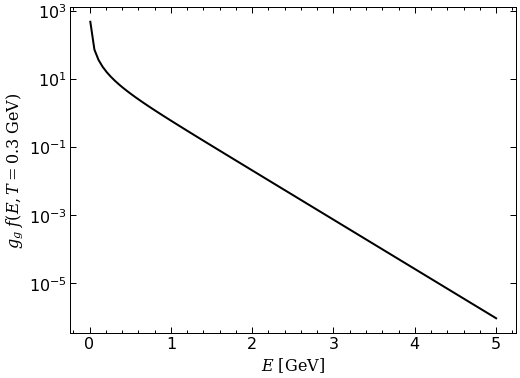

In [19]:
def fgluon(E, T=0.3, g_deg=16):
    '''QGP 中胶子的热分布函数
    :E: the energy of the thermal parton 
    :T: the medium temperature
    :g_deg: the gluon degeneracy 2*8 = 16'''
    return g_deg / (np.exp(E/T) - 1)

E = np.linspace(0.01, 5, 100)
plt.semilogy(E, fgluon(E), 'k')
plt.xlabel(r"$E\ {\rm [GeV]}$")
plt.ylabel(r'$g_g\ f(E, T=0.3\ {\rm GeV})$')

In [20]:
def M2_gg2gg(s, t, u, alphas=0.3):
    '''gluon+gluon to gluon+gluon scattering amplitude square'''
    coef = 9/2 * gs(alphas)**4
    return coef * (3 - u * t/s**2 - u*s/t**2 - s*t/u**2)

In [21]:
def Vegas_Gamma_ij2kl(M2, fj, T, E1, alphas=0.3, sm=1, delta_kl=1):
    '''PRC 82, 024906(2010) A9
    :Omega: Eq. (A9), as a function of (E1, E2, msquare)
    :fj: distribution function for parton j in medium
    :return: scattering rate
    '''
    coef = 1/(16 * np.pi**2 * E1**2)
    coef *= 1 / (1 + delta_kl) / (16 * np.pi)
    m = mass_cutoff(T, sm=sm, alphas=alphas)
    
    lower_bound = m*m / (2 * E1)
    # set the maximum energy of thermal parton to be 50T
    upper_bound = 100 * T
    
    def f(x):
        E2, s, t = x[0], x[1], x[2]
        if (t < -s + m*m) or (t > - m*m):
            return 0
        
        if (s < 2*m*m) or (s > 4*E1*E2):
            return 0
        
        u = - (s + t)
        return coef * fj(E2, T) * M2(s, t, u, alphas) / s
        
    integ = vegas.Integrator([[lower_bound, upper_bound],
                              [2*m**2, 100], [-100, -m*m]])
    
    result = integ(f, nitn=20, neval=100000)
    return result

In [22]:
Vegas_Gamma_ij2kl(M2_gg2gg, fgluon, T=0.3, E1=5)

0.16546(24)

In [23]:
# 产生温度为 T=0.5 GeV，入射部分子能量为 2 到 50 GeV 的 gg->gg 散射率

T = 0.5

E1arr = np.linspace(2, 50, 20)

res = [Vegas_Gamma_ij2kl(M2_gg2gg, fgluon, T, E1) for E1 in tqdm(E1arr)]

100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


Text(0, 0.5, '$\\Gamma_{gg\\rightarrow gg}$')

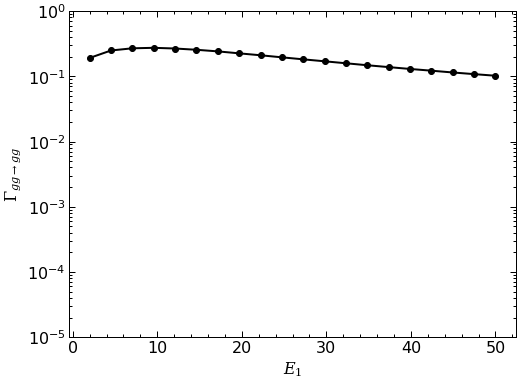

In [24]:
res_mean = [r.mean for r in res]
res_var = [r.sdev for r in res]
plt.semilogy(E1arr, res_mean, 'ko-')
plt.ylim(1.0E-5, 1)
plt.xlabel(r'$E_1$')
plt.ylabel(r'$\Gamma_{gg\rightarrow gg}$')

## 部分子输运 Parton cascade

1. ZPC：Zhang Bin's Parton cascade https://arxiv.org/pdf/nucl-th/9709009.pdf
2. BAMPS (Xu Zhe)  https://arxiv.org/pdf/hep-ph/0406278.pdf 

部分子输运模型使用玻尔兹曼方程描述重离子碰撞产生的大量夸克、胶子的散射。

\begin{align}
\left(\frac{\partial}{\partial t}+\frac{\mathbf{p}_{1}}{E_{1}} \frac{\partial}{\partial \mathbf{r}}\right) f_{1}\left(\mathbf{r}, \mathbf{p}_{1}, t\right)=\mathcal{C}_{22}+\mathcal{C}_{23}+\cdots,
\end{align}

其中 $f_1$ 是第一个部分子的相空间分布函数，$\mathcal{C}_{22}, \mathcal{C}_{23}$ 分别对应 2 到 2 和 2 到 3 的散射过程。

虽然 ZPC 与 BAMPS 都是部分子输运程序，包含无碰撞时的 free streaming 和参与碰撞时的粒子动量更新，
但它们的实现细节有所不同。

ZPC 中，使用 total crosssection 来判断两个胶子是否会发生碰撞。碰撞判据为，

\begin{align}
r \lt \sqrt{\sigma \over \pi}, \quad\ \sigma = {9 \pi \alpha_s^2 \over 2 \mu^2}
\end{align}

使用胶子胶子散射的微分散射截面来抽样散射极角 $\theta$。

\begin{align}
{d \sigma \over dt} = {9 \pi \alpha_s^2 \over 2 \mu^2} \left(1 + {\mu^2 \over s} \right) {1 \over (t - \mu)^2}
\end{align}

其中 $\mu$ 是德拜屏蔽质量。(注意这里 $t = (p_1 - p_3)^2$ 与 $\mu$ 量纲不一致, 可能因为是人工截断，ZPC 作者并未考虑量纲一致性)

BAMPS 加入了 $gg\rightarrow ggg$ 非弹性过程，并考虑了如果部分子密度很大时玻尔兹曼方程（适用于稀薄气体）失效的问题。

当平均自由程远小于 $\sqrt{\sigma/\pi}$ 时，需要考虑多体散射，像 $3\rightarrow 2$ 这样的过程尤其不好处理。

BAMPS 使用与 LBT 类似的思路：根据单位时间和体积内两个部分子的散射率 $P_{22}$，抽样决定某个部分子是否发生散射。

BAMPS 把 ZPC 类算法称为“几何算法”，因为使用散射截面作为碰撞判据有很强的几何意味，而把抽样方法称为“随机散射过程”。

BAMPS 中使用的几个微分散射截面为，

\begin{align}
\frac{d \sigma^{g g \rightarrow g g}}{d q_{\perp}^{2}} &=\frac{9 \pi \alpha_{s}^{2}}{\left(q_{\perp}^{2}+m_{D}^{2}\right)^{2}} \\
\frac{d \sigma^{g g \rightarrow q \bar{q}}}{d q_{\perp}^{2}} &=\frac{\pi \alpha_{s}^{2}}{3 s\left(q_{\perp}^{2}+m_{q}^{2}\right)} \\
\left|\mathcal{M}_{g g \rightarrow g g g}\right|^{2} &=\left(\frac{9 g^{4}}{2} \frac{s^{2}}{\left(\mathbf{q}_{\perp}^{2}+m_{D}^{2}\right)^{2}}\right)\left(\frac{12 g^{2} \mathbf{q}_{\perp}^{2}}{\mathbf{k}_{\perp}^{2}\left[\left(\mathbf{k}_{\perp}-\mathbf{q}_{\perp}\right)^{2}+m_{D}^{2}\right]}\right),
\end{align}

核核碰撞中初始部分子的产生可以使用核子核子碰撞 + 碰撞几何得到，

\begin{align}
\frac{d \sigma_{j e t}}{d p_{T}^{2} d y_{1} d y_{2}}=K \sum_{a, b} x_{1} f_{a}\left(x_{1}, p_{T}^{2}\right) x_{2} f_{b}\left(x_{2}, p_{T}^{2}\right) \frac{d \sigma_{a b}}{d \hat{t}}
\end{align}

其中 $f_a$ 和 $f_b$ 是核子中的部分子分布函数。$x_1$, $x_2$ 是纵向动量分数。

### 实现一个简单的 Parton cascade

高能物理中的分子动力学模拟与计算化学中的分子动力学模拟有所不同。

计算化学中，相互作用力一般为长程力，使用经典哈密顿运动方程与辛几何算法（如 Verlet 算法）求解系统的演化。

高能物理中，“几何算法”下，部分子散射、强子散射一般使用散射截面和微分散射截面决定是否发生碰撞，

以及发生碰撞后末态粒子的动量改变。

接下来只考虑 $gg\rightarrow gg$ 的弹性散射，仿照 ZPC 模型，实现一个简单的部分子散射模型。

1. ZPC 中取德拜屏蔽质量 $\mu=4.5 fm^{-1}$, $\alpha_s=0.4$, 得到总散射截面 $\sigma \approx 10 \ fm^2$。
2. 最短碰撞距离 $r = \sqrt{\sigma / \pi} = 1.784$ fm
3. 根据 $ \frac{d \sigma^{g g \rightarrow g g}}{d q_{\perp}^{2}} =\frac{9 \pi \alpha_{s}^{2}}{\left(q_{\perp}^{2}+m_{D}^{2}\right)^{2}}$  抽样横向动量转移 $q_{\perp}$, 得到末态粒子的四动量。



一个大的仿真程序总是从简化的假设下做起，在这个简单的版本中，我们假设

1. 每个 parton 只与距离最近的发生碰撞，碰撞后散射角各向同性
2. 碰撞发生在一个 2 维 10 fm 长， 10 fm 宽的 box 中
3. 初始化（1）：N 个胶子均匀的分布在 box 的坐标空间中
4. 初始化（2）：这些胶子的动量初始化为均匀分布 $p\sim U[0, 3]$ GeV
5. 使用周期性边界条件，从 box 右边界飞出的部分子会以同样的速度进入 box 的左边界

In [25]:
# step 1: 先计算 gg->gg 总的散射截面, 确定几何上最短碰撞距离

def sig_total(alphas=0.3, mu=0.35):
    '''total cross section of gg->gg elastic scattering
    :alphas: strong coupling constant
    :mu: Debye screening mass, unit [fm^{-1}]
    
    :return: total cross section, unit [fm^2]'''
    return 9 * np.pi *alphas**2 / (2 * mu**2)
    
sig_total()

10.386489997582583

In [26]:
def colliding_distance(sigma=10):
    return np.sqrt(sigma / np.pi)

rmin = colliding_distance(sigma=10)

print("Colliding distance = %.3f fm"%rmin)

Colliding distance = 1.784 fm


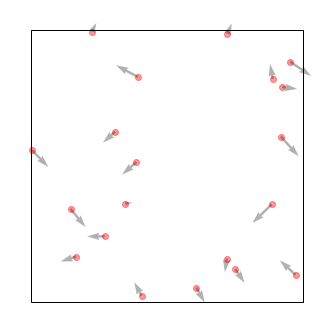

In [27]:
# step 2: 初始化胶子的坐标与动量 (假设横轴为 z，纵轴为 x 方向)
def plot_partons(z, y, pz, py, box, show_momentum=True):
    box.plot()
    plt.scatter(z, y, color='r', alpha=0.4)
    if show_momentum:
        plt.quiver(z, y, pz, py, alpha=0.3)  

def partons_initialization(n, box, pmax=3):
    ''':n: num of partons
    :box: the Box2D type object '''
    z = np.random.uniform(low=box.xmin, high=box.xmax, size=n)
    y = np.random.uniform(low=box.ymin, high=box.ymax, size=n)
    pz = np.random.uniform(low=-pmax, high=pmax, size=n)
    py = np.random.uniform(low=-pmax, high=pmax, size=n)
    return z, y, pz, py

z, y, pz, py = partons_initialization(n=20, box=box)
plot_partons(z, y, pz, py, box)

In [28]:
# free streaming (测试无碰撞情况下粒子的运动)
def free_stream(dt, z, y, pz, py, box, mass=0.1):
    '''Assume gluons have thermal mass = 0.1 GeV'''
    E = np.sqrt(mass*mass + pz*pz + py*py)
    vz = pz / E
    vy = py / E
    z1 = z + vz * dt
    y1 = y + vy * dt
    # 周期性边界条件 (此处也可使用反射边界条件)
    z1 = np.where(z1 > box.xmax, box.xmin, z1)
    z1 = np.where(z1 < box.xmin, box.xmax, z1)
    y1 = np.where(y1 > box.ymax, box.ymin, y1)
    y1 = np.where(y1 < box.ymin, box.ymax, y1)
    
    return z1, y1, pz, py

history = []
dt = 0.1
z, y, pz, py = partons_initialization(n=10, box=box)
for i in range(100):
    z, y, pz, py = free_stream(dt, z, y, pz, py, box)
    history.append((z, y, pz, py))

In [29]:
@interact(n=(0, 99, 1))
def plot_freestreaming(n):
    z, y, pz, py = history[n]
    plot_partons(z, y, pz, py, box)

interactive(children=(IntSlider(value=49, description='n', max=99), Output()), _dom_classes=('widget-interact'…

## 粒子碰撞运动学

在质心系中，无质量胶子胶子弹性碰撞后粒子3的动量大小等于粒子1， 

设 $p_1^{\mu} = (p_1, 0, 0, p_1)$,

$p_3^{\mu} = (p_1, 0, p_1\sin \theta, p_1 \cos\theta)$

\begin{align}
t &= (p_1 - p_3)^2 = g_{\mu\nu} p_1^{\mu} p_3^{\nu}\\
& = - 2 p_1 \cdot p_3 \\
& =- 2 p_1^2 (1 - \cos \theta)
\end{align}

可以得到，

\begin{align}
 \cos \theta &= 1 + {t \over 2  p_1^2 } =  1 + {2 t \over s}
\end{align}

碰撞时，可以先把系统 Lorentz boost 到参与碰撞的两个粒子的质心系，

在质心系中让粒子 1 与 2 发生碰撞，碰撞后粒子1散射角为 $\theta$, 更新其动量(即出射粒子，重新标记为 3)，

\begin{align}
 p_3^z = p_1 \cos \theta \\
 p_{3}^{\perp} = p_1 \sin\theta
\end{align}

在我们的 2D box 例子中，$p_3^{\perp}=p_3^y$, 再将其 Lorentz boost 到实验室系。

如果我们知道参考系的速度沿 z 方向，则 lorentz boost 非常简单，

使用 Lorentz bost 矩阵，

\begin{align}
\begin{bmatrix} E'\\ 0\\ 0\\ p_z'\end{bmatrix}
= \begin{bmatrix} 
\gamma & 0 & 0 & -\gamma \beta \\
0 & 1 & 0 & 0 \\
0& 0 & 1 & 0 \\
-\gamma\beta & 0 & 0 & \gamma \\
\end{bmatrix}
\begin{bmatrix} E\\ 0\\ 0\\ p_z\end{bmatrix}
\end{align}

其中 $\beta = {v_z \over c}$, $\gamma = {1 \over \sqrt{1 - \beta^2}}$。 

也可以仿照 Lorentz 旋转，定义 $\cosh y = \gamma$, $\sinh y = \gamma\beta$, 此时 $v_z/c = \tanh y$。

对于质心系沿着 $v = (v_x, v_y, v_z)$ 这样的任意方向，有一个通用的 Lorentz 变换矩阵，

\begin{bmatrix}
\gamma & -\gamma v_{x} / c & -\gamma v_{y} / c & -\gamma v_{z} / c \\
-\gamma v_{x} / c & 1+(\gamma-1) \frac{v_{x}^{2}}{v^{2}} & (\gamma-1) \frac{v_{x} v_{y}}{v^{2}} & (\gamma-1) \frac{v_{x} v_{z}}{v^{2}} \\
-\gamma v_{y} / c & (\gamma-1) \frac{v_{y} v_{x}}{v^{2}} & 1+(\gamma-1) \frac{v_{y}^{2}}{v^{2}} & (\gamma-1) \frac{v_{y} v_{z}}{v^{2}} \\
-\gamma v_{z} / c & (\gamma-1) \frac{v_{z} v_{x}}{v^{2}} & (\gamma-1) \frac{v_{z} v_{y}}{v^{2}} & 1+(\gamma-1) \frac{v_{z}^{2}}{v^{2}}
\end{bmatrix}

读多相输运模型 AMPT 中的 ZPC.f 代码，或者强子输运模型 SMASH 的代码，都会看到这个实现， 比如 ZPC.f 中，

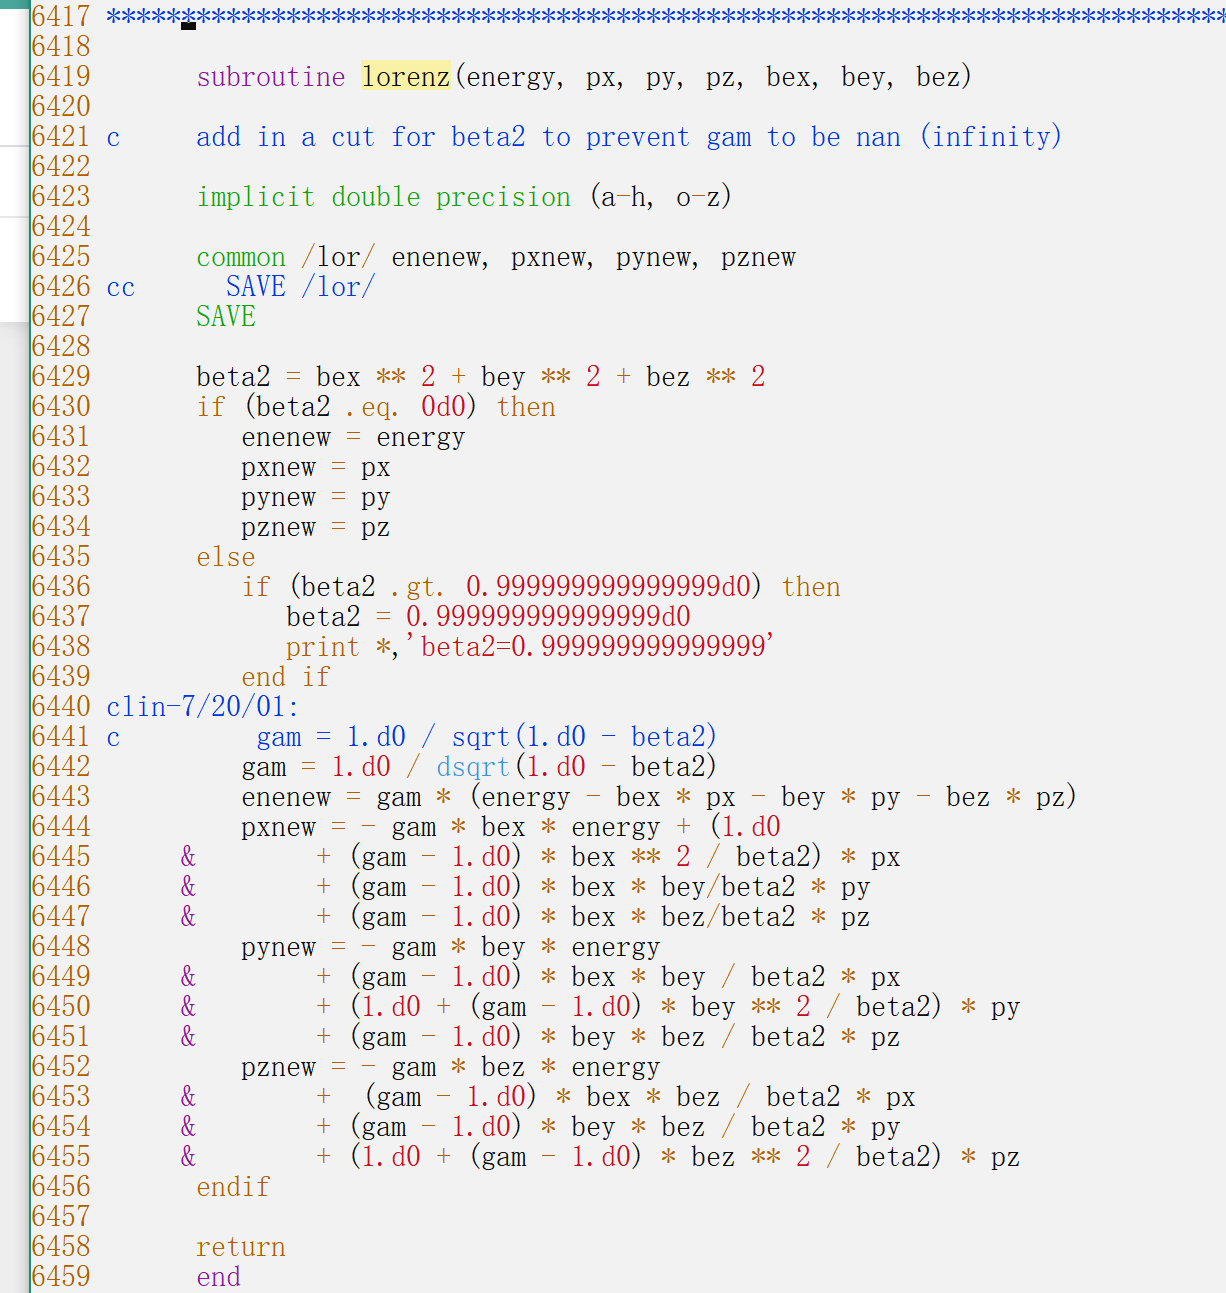

In [30]:
Image("images/LorentzBoost.png", width=500)

上述 Lorentz 变换矩阵也会被用在粒子衰变仿真中，

比如，核碰撞或粒子碰撞产生的末态大量不稳定粒子，如果想计算两体或三体衰变的末态产物，

可以先 Lorentz boost 到母粒子的 Local rest frame, 抽样衰变后子粒子的动量，

最后再 Lorentz boost 反变换，回到实验室坐标系。

## 参考文献

1. PRC 82， 024906 （2010）
2. arXiv:1503.03313v1 
3. [QCD Matrix element](http://www.matfis.uniroma3.it/Allegati/Dottorato/CORSI/Materiale/10013_300/Lecture%203%20-%20Cross%20Section%20Measurements.pdf)
4. 计算物理（第2版） Nicholas J.Giordano, Hisao Nakanishi